In [0]:
import tensorflow as tf

from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython import display
import imageio


In [0]:
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype("float32")
train_images = (train_images - 127.5) / 127.5
Buffer_size = 60000
Batch_size = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(Buffer_size).batch(Batch_size)

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2), padding='same', use_bias=False, activation="tanh"))
  return model

In [0]:
generator = make_generator_model()

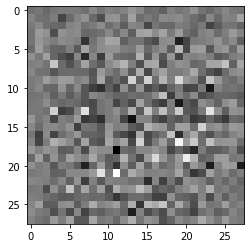

In [36]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0], cmap="gray")

In [0]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5), strides=(2,2), padding="same", input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [38]:
discriminator = make_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00198444]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return fake_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
Epochs = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([Batch_size, noise_dim])
  with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)
    gen_loss = generator_loss(fake_output)
    discrim_loss = discriminator_loss(real_output, fake_output)
  gradients_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_discriminator = gen_tape.gradient(discrim_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
    

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset :
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
    if (epoch) % 1 == 0:
      print("Epoch", epoch)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap="gray")
  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

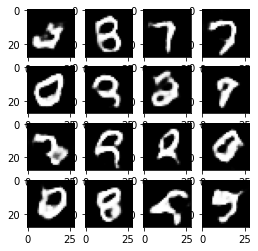

In [0]:
train(train_dataset, Epochs)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
train_data_